In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
#pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit 

/home/habiba/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Download the Heart Failure Prediction Dataset


In [ ]:
# Download the dataset (returns the path to the dataset folder)
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

# Load the dataset with pandas
dataset = pd.read_csv(dataset_path)

# Display the dataset
dataset

## Step 2: Dataset Preparation

In [ ]:
#Setting a random seed ensures that any random processes produce the same results each time the code is run.
import random
random.seed(42)

### Feature Preprocessing

In [ ]:
X = dataset.drop(columns="HeartDisease")  # All columns except the target --> feature matrix
y = dataset["HeartDisease"]               # Target column --> target vector

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()   # scale features between 0 and 1 -> (x - min) / (max - min)
# scalar = StandardScaler() # scale features to have mean=0 and variance=1 -> (x - mean) / std

# Normalize only numeric columns
for col in X.columns:
    if pd.api.types.is_numeric_dtype(X[col]):
        X[col] = scaler.fit_transform(X[[col]])
X

In [ ]:
# Categorical features one-hot encoding
cat_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
print(X.head())


### Train/Validation/Test Split

In [ ]:
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, 
    random_state=42,   # For reproducibility ------> no need for shuffling
    test_size=0.3,     # 30% for testing and validation, 70% for training
    stratify=y
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test_val, y_test_val, 
    random_state=42,   # For reproducibility ------> no need for shuffling
    test_size=1/3,     # 20% for testing, 10% for validation of the whole dataset
    stratify=y_test_val
)

# Ensuring Ratio between number of zeros and ones are the same for all sets
print("Test Set: ")
print(y_test.value_counts())
print("Ratio = ", y_test.value_counts()[0]/y_test.value_counts()[1])
print("---------------------------------------")
print("Validation Set: ")
print(y_val.value_counts())
print("Ratio = ", y_val.value_counts()[0]/y_val.value_counts()[1])
print("---------------------------------------")
print("Training Set: ")
print(y_train.value_counts())
print("Ratio = ", y_train.value_counts()[0]/y_train.value_counts()[1])
print("---------------------------------------")

print(len(X_train), len(X_test), len(X_val))
print(len(X), len(y))
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

## Step 3: Implementation

Working with a range of classification algorithms from scratch:
1. Decision Tree
2. Bagging Ensemble
3. AdaBoost Ensemble

## Step 3.1: Decision Tree 

In [205]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature  # Index of the feature to split on
        self.threshold = threshold  # Threshold value for splitting
        self.left = left # Left child node
        self.right = right # Right child node
        self.value = value  # Value aw el Class label if the node is a leaf node
        

In [206]:
class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None    # Root node
    
    # Calculate the entropy of a list of labels
    def entropy(self, y):
        label_count = np.bincount(y)  
        probabilities = label_count / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    
    # Calculate the information gain of a split
    def information_gain(self, X_feature_column, y, threshold):
        parent_entropy = self.entropy(y)
        
        # Split the data
        left_indices = X_feature_column < threshold
        right_indices = X_feature_column >= threshold
        
        # Ignore the split if it doesn't divide the data
        if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
            return 0
        
        # Calculate the weighted avg entropy of the children
        n, left_n, right_n = len(y), len(y[left_indices]), len(y[right_indices])
        # n, left_n, right_n = len(y), sum(left_indices), sum(right_indices)
        left_entropy = self.entropy(y[left_indices])
        right_entropy = self.entropy(y[right_indices])
        weighted_avg_child_entropy = (left_n / n) * left_entropy + (right_n / n) * right_entropy
        
        # Calculate the information gain
        return parent_entropy - weighted_avg_child_entropy
    
    # Find the best feature and threshold to split on
    def best_split(self, X, y):
        best_gain = -1
        best_feature, best_threshold = None, None
        
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])   #try all unique values in the feature as thresholds
            for threshold in thresholds:
                gain = self.information_gain(X[:, feature], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    # Build the decision tree recursively
    def build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))        # num of classes
        
        # Stopping conditions
        if depth >= self.max_depth or n_samples < self.min_samples_split or n_labels == 1:
            leaf_value = np.argmax(np.bincount(y))      #majority class label
            return Node(value=leaf_value)
        
        # Find the best split
        best_feature, best_threshold = self.best_split(X, y)
        
        if best_feature is None or best_threshold is None:
            leaf_value = np.argmax(np.bincount(y))
            return Node(value=leaf_value) 
            # return Node(value=np.argmax(np.bincount(y)))
        
        # Split the data
        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold
        
        left_child = self.build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self.build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return Node(best_feature, best_threshold, left_child, right_child)
    
    # Train the decision tree
    def fit(self, X, y):
        self.root = self.build_tree(X, y)
    
    # Predict the class of a single sample
    def predict(self, x_sample, node=None):
        if node is None:
            node = self.root
        
        if node.value is not None:
            return node.value
        
        if x_sample[node.feature] < node.threshold:
            return self.predict(x_sample, node.left)
        else:
            return self.predict(x_sample, node.right)
        
    # Predict the classes of multiple samples
    def predict_all(self, X):
        return np.array([self.predict(x_sample, self.root) for x_sample in X])

In [207]:
# Train the decision tree
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, confusion_matrix

# dict_decision_tree = {}
results_decision_tree = {}
val_f1_score_list = []  # Initialize the list to store the results
train_f1_score_list = []

for depth in range(2, 16, 1):
    train_accuracy_decision_tree, val_accuracy_decision_tree = [], []
    train_f1_score_decision_tree, val_f1_score_decision_tree = [], []
    
    for min_samples in range(2, 11, 2):
        y_pred_train = None
        y_pred_val = None
        tree = DecisionTree(max_depth=depth, min_samples_split=min_samples)
        tree.fit(X_train.values, y_train.values)
        
        # Predict the classes of the test set
        y_pred_train = tree.predict_all(X_train.values)
        train_accuracy = round(accuracy_score(y_train, y_pred_train) * 100, 3)
        f1_score_train = round(f1_score(y_train, y_pred_train, average='macro') * 100, 3)
        train_f1_score_decision_tree.append(f1_score_train)
        train_accuracy_decision_tree.append(train_accuracy)
        
        # Predict the classes of the validation set
        y_pred_val = tree.predict_all(X_val.values)
        val_accuracy = round(accuracy_score(y_val, y_pred_val) * 100, 3)
        f1_score_val = round(f1_score(y_val, y_pred_val, average='macro') * 100, 3)
        val_f1_score_decision_tree.append(f1_score_val)
        val_accuracy_decision_tree.append(val_accuracy)
        
        # Append the results to the list
        val_f1_score_list.append({'Depth': depth, 'Min Samples': min_samples, 'Validation F1 Score': f1_score_val})
        train_f1_score_list.append({'Depth': depth, 'Min Samples': min_samples, 'Train F1 Score': f1_score_train})
    
    results_decision_tree[depth] = {
        "train_accuracy": train_accuracy_decision_tree,
        "val_accuracy": val_accuracy_decision_tree,
        "train_f1_score": train_f1_score_decision_tree,
        "val_f1_score": val_f1_score_decision_tree,
    }


# Create a DataFrame from the list
val_f1_score_df = pd.DataFrame(val_f1_score_list)

# Pivot the DataFrame to represent depth as columns and min_samples as rows
val_f1_score_pivot = val_f1_score_df.pivot(index='Min Samples', columns='Depth', values='Validation F1 Score')
val_f1_score_pivot = val_f1_score_pivot.applymap(lambda x: f"{x}%")

train_f1_score_df = pd.DataFrame(train_f1_score_list)
train_f1_score_pivot = train_f1_score_df.pivot(index='Min Samples', columns='Depth', values='Train F1 Score')
train_f1_score_pivot = train_f1_score_pivot.applymap(lambda x: f"{x}%")





In [208]:
train_f1_score_pivot

Depth,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Min Samples,,,,,,,,,,,,,,
2,82.971%,84.867%,87.074%,88.526%,91.745%,93.37%,95.577%,98.268%,99.055%,100.0%,100.0%,100.0%,100.0%,100.0%
4,82.971%,84.867%,87.074%,88.526%,91.745%,93.21%,95.105%,97.639%,98.111%,98.74%,98.74%,98.74%,98.74%,98.74%
6,82.971%,84.867%,87.074%,88.526%,91.435%,92.899%,94.481%,96.229%,96.699%,96.699%,96.699%,96.699%,96.699%,96.699%
8,82.971%,84.867%,87.074%,88.365%,91.125%,92.423%,93.059%,94.813%,95.127%,95.127%,95.127%,95.127%,95.127%,95.127%
10,82.971%,84.867%,87.074%,88.365%,91.125%,92.423%,92.888%,94.022%,94.029%,94.029%,94.029%,94.029%,94.029%,94.029%


In [209]:
val_f1_score_pivot

Depth,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Min Samples,,,,,,,,,,,,,,
2,78.927%,82.534%,83.538%,84.718%,83.538%,83.601%,83.601%,84.718%,83.601%,84.718%,84.718%,84.718%,84.718%,84.718%
4,78.927%,82.534%,83.538%,84.718%,83.538%,83.601%,83.601%,84.718%,83.601%,84.718%,84.718%,84.718%,84.718%,84.718%
6,78.927%,82.534%,83.538%,84.718%,83.538%,83.601%,83.601%,84.718%,83.601%,83.601%,83.601%,83.601%,83.601%,83.601%
8,78.927%,82.534%,83.538%,84.718%,83.538%,83.601%,82.534%,83.647%,82.534%,82.534%,82.534%,82.534%,82.534%,82.534%
10,78.927%,82.534%,83.538%,84.718%,83.538%,83.601%,83.601%,84.718%,84.718%,84.718%,84.718%,84.718%,84.718%,84.718%


In [210]:
print("Train Accuracy: ",results_decision_tree[5]['train_accuracy'][0], '%')
print("Train F1 Score: ", results_decision_tree[5]['train_f1_score'][0], '%')
print("Validation Accuracy: ", results_decision_tree[5]['val_accuracy'][0], '%')
print("Validation F1 Score: ", results_decision_tree[5]['val_f1_score'][0], '%')

Train Accuracy:  88.629 %
Train F1 Score:  88.526 %
Validation Accuracy:  84.783 %
Validation F1 Score:  84.718 %


Best Hyperparameters: Depth = 5 and Min Samples = 2
Best Validation Accuracy: 84.7830%
Validation F1 Score: 84.7176%


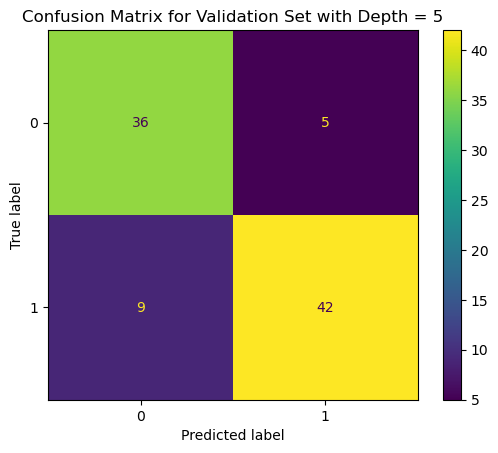

Training Set Results, For Depth =  5  and Min Samples =  2
Train Accuracy =  88.629 %
Train F1 Score =  88.526 %


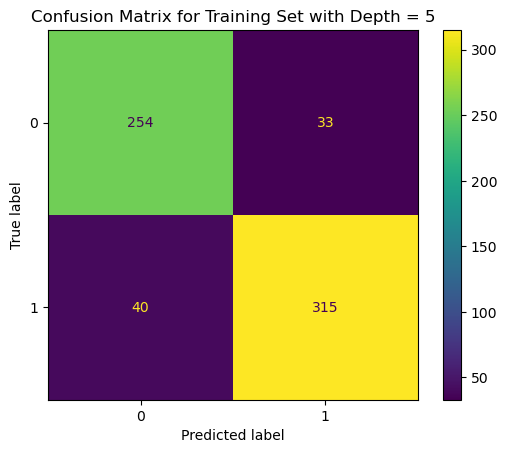

In [211]:
# Find the best hyperparameters

best_depth = None
best_min_samples = None
best_val_accuracy = 0

for depth, metrics in results_decision_tree.items():
    for i, val_acc in enumerate(metrics["val_accuracy"]):
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_depth = depth
            best_min_samples = i + 2  # since min_samples starts from 2

print(f"Best Hyperparameters: Depth = {best_depth} and Min Samples = {best_min_samples}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}%")

# Train the decision tree with the best hyperparameters
tree = DecisionTree(max_depth=best_depth, min_samples_split=5)
tree.fit(X_train.values, y_train.values)

# Predict the classes of the validation set
# y_val_pred = tree.predict_all(X_val.values)

# Calculate the F1 score for the validation set
f1_score_val = f1_score(y_val, y_pred_val, average='macro')
print(f"Validation F1 Score: {f1_score_val * 100:.4f}%")

# Display the confusion matrix for the validation set
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(2)))
disp.plot(cmap='viridis', values_format='d')
plt.title(f"Confusion Matrix for Validation Set with Depth = {best_depth}")
plt.show()

print("Training Set Results, For Depth = ", best_depth, " and Min Samples = ", best_min_samples)
print("Train Accuracy = ", results_decision_tree[best_depth]['train_accuracy'][best_min_samples-2], "%")
print("Train F1 Score = ", results_decision_tree[best_depth]['train_f1_score'][best_min_samples-2], "%")

# Display the confusion matrix for the training set with the best hyperparameters
y_train_pred = tree.predict_all(X_train.values)
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=list(range(2)))
disp_train.plot(cmap='viridis', values_format='d')
plt.title(f"Confusion Matrix for Training Set with Depth = {best_depth}")
plt.show()



Test Accuracy: 85.3261%
Test F1 Score: 85.3169%


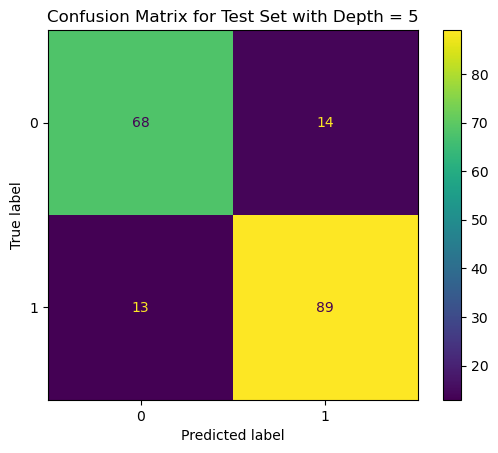

In [214]:
# Train the final model with the best hyperparameters
test_tree = DecisionTree(max_depth=best_depth, min_samples_split=best_min_samples)
test_tree.fit(X_train.values, y_train.values)

# Predict the classes of the test set with the best hyperparameters
y_test_pred = test_tree.predict_all(X_test.values)

# Computr test accuracy and F1 score on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.4f}%")
test_f1_score = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test F1 Score: {test_f1_score * 100:.4f}%")

# Display the confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(2)))
disp.plot(cmap='viridis', values_format='d')
plt.title(f"Confusion Matrix for Test Set with Depth = {best_depth}")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

class AdaBoost:

    def __init__(self, X_train, X_test, X_val, y_train, y_test, y_val):
        # Initialize datasets
        self.X_train = X_train
        self.X_test = X_test
        self.X_val = X_val
        self.y_train = y_train
        self.y_test = y_test
        self.y_val = y_val

        # Initialize weights uniformly across all training samples
        self.weights = np.ones(len(y_train)) / len(y_train)

        # Store alpha values (model contributions) and weak learners
        self.alphaArr = []
        self.decision_trees = []

    def error(self, predicted, y):
        """ Calculate the weighted error (sum of weights for misclassified points). """
        return np.sum(self.weights * (predicted != y)) / np.sum(self.weights)

    def alpha(self, errorVal):
        """ Calculate the model's contribution (alpha) using the error. """
        # Clip error to avoid division by zero or taking log(0)
        errorVal = np.clip(errorVal, 1e-10, 1 - 1e-10)
        return 0.5 * np.log((1 - errorVal) / errorVal)

    def reweight(self, predicted, alphaVal):
        """ Update weights to focus on misclassified samples. """
        # Misclassified points get higher weights
        self.weights *= np.exp(alphaVal * (predicted != self.y_train))

        # Normalize weights to sum to 1
        self.weights /= np.sum(self.weights)

    def _train_(self):
        """ Train a weak learner (decision stump) for one iteration. """
        # Create and fit a decision tree with max_depth=1 (stump)
        dtree = DecisionTreeClassifier(max_depth=1)
        dtree.fit(self.X_train, self.y_train, sample_weight=self.weights)

        # Predict on the training set
        prediction = dtree.predict(self.X_train)

        # Calculate weighted error
        err = self.error(prediction, self.y_train)

        # Only add weak learners with error < 0.5
        if err < 0.5:
            # Compute the model's contribution (alpha)
            alphaVal = self.alpha(err)

            # Store the model and its alpha value
            self.decision_trees.append(dtree)
            self.alphaArr.append(alphaVal)

            # Update sample weights
            self.reweight(prediction, alphaVal)

        return prediction, err

    def train(self):
        """ Train the AdaBoost ensemble model. """
        # Initialize variables
        final_res = np.zeros(len(self.y_train))
        iteration_max = 50
        error_diff_threshold = 0.05
        overfit_count = 0
        overfit_limit = 5

        train_errors = []
        val_errors = []

        for i in range(iteration_max):

            # Train a weak learner
            prediction, err = self._train_()

            # Stop if error exceeds or equals 0.5
            if err >= 0.5:
                print(f"Stopping early at iteration {i} (error={err:.4f})")
                break

            # Calculate training error
            trainError = np.sum(prediction != self.y_train) / len(self.y_train)

            # Map predictions to {-1, 1} for AdaBoost math
            prediction = np.where(prediction == 0, -1, 1)
            final_res += self.alphaArr[i] * prediction

            # Store training error for visualization
            train_errors.append(trainError)

            # Stop if perfect fit is achieved
            if err == 0:
                print(f"Perfect fit at iteration {i}.")
                break

            # Validate on validation set
            val = self.validate()
            val_errors.append(val)

            # Check for overfitting based on error difference
            if abs(val - trainError) > error_diff_threshold:
                overfit_count += 1
            else:
                overfit_count = 0

        #     # Handle overfitting by trimming models
        #     if overfit_count >= overfit_limit:
        #         print(f"Detected Overfitting at iteration {i}.")
        #         print(f"Just keep {i-overfit_limit} weak learners.")

        #         # Remove last overfit_limit models
        #         if len(self.decision_trees) >= overfit_limit:
        #             self.decision_trees = self.decision_trees[:-overfit_limit]
        #             self.alphaArr = self.alphaArr[:-overfit_limit]

        #             # Recompute final result
        #             final_res = np.zeros(len(self.y_train))
        #             for j in range(len(self.decision_trees)):
        #                 prediction = self.decision_trees[j].predict(self.X_train)
        #                 prediction = np.where(prediction == 0, -1, 1)
        #                 final_res += self.alphaArr[j] * prediction

        #         break

        # Plot training vs validation error
        plt.plot(range(len(train_errors)), train_errors, label='Training Error')
        plt.plot(range(len(val_errors)), val_errors, label='Validation Error')
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.title('Training vs Validation Error')
        plt.legend()
        plt.show()

        return np.where(final_res > 0, 1, 0)

    def validateOrTest(self, x_test_val, y_test_val):
        """ Predict using the ensemble of weak learners. """
        final_res = np.zeros(len(y_test_val))

        for i in range(len(self.decision_trees)):
            prediction = self.decision_trees[i].predict(x_test_val)
            prediction = np.where(prediction == 0, -1, 1)
            final_res += self.alphaArr[i] * prediction

        return np.where(final_res > 0, 1, 0)

    def test(self):
        """ Evaluate the model on the test set. """
        prediction = self.validateOrTest(self.X_test, self.y_test)
        return np.sum(prediction != self.y_test) / len(self.y_test)

    def validate(self):
        """ Evaluate the model on the validation set. """
        prediction = self.validateOrTest(self.X_val, self.y_val)
        return np.sum(prediction != self.y_val) / len(self.y_val)

    def predict(self, x):
        """ Predict a single sample. """
        final_res = 0

        for i in range(len(self.decision_trees)):
            prediction = self.decision_trees[i].predict(x)
            prediction = np.where(prediction == 0, -1, 1)
            final_res += self.alphaArr[i] * prediction

        return 1 if final_res > 0 else 0

    def evaluate(self, x, y, dataset_name="Test"):
        """ Evaluate the model on a given dataset and display accuracy, F1-score, and confusion matrix. """
        # Get predictions
        predictions = self.validateOrTest(x, y)

        # Calculate metrics
        acc = accuracy_score(y, predictions)
        f1 = f1_score(y, predictions)
        cm = confusion_matrix(y, predictions)

        print(f"{dataset_name} Set Evaluation:")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1-Score: {f1:.4f}\n")

        # Display confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f"{dataset_name} Set Confusion Matrix")
        plt.show()

    def full_evaluation(self):
        """ Evaluate the model on training, validation, and test sets. """
        self.evaluate(self.X_train, self.y_train, "Training")
        self.evaluate(self.X_val, self.y_val, "Validation")
        self.evaluate(self.X_test, self.y_test, "Test")


Training Set Evaluation:
Accuracy: 0.8536
F1-Score: 0.8691



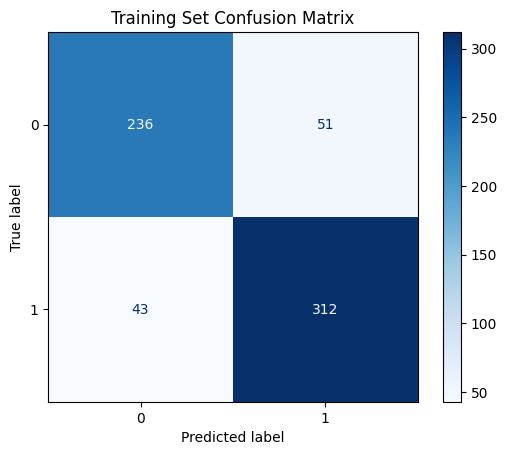

Validation Set Evaluation:
Accuracy: 0.8696
F1-Score: 0.8776



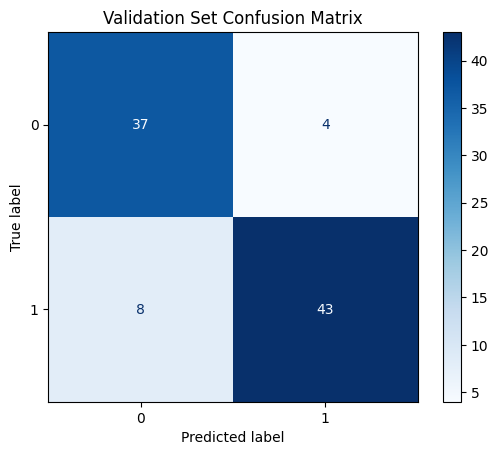

Test Set Evaluation:
Accuracy: 0.8967
F1-Score: 0.9082



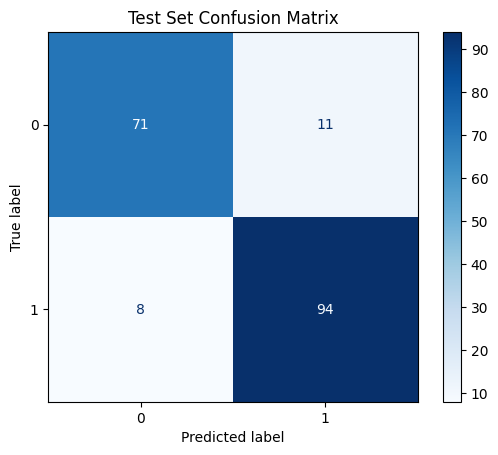

'done'

In [14]:
model = AdaBoost(X_train, X_test, X_val, y_train, y_test, y_val )
tr =model.train()
t =model.test()
v = model.validate()
model.full_evaluation()



"""to be done"""
"""done"""
# need to put a fixed threshold on the diff between the tr error and val error  to detect overfitting
# put limit on the max number of iterations  


In [12]:
import pandas as pd
import numpy as np

# Create a sample DataFrame
sample = pd.DataFrame({
    'Age': [0.37],
    'RestingBP': [0.80],
    'Cholesterol': [0.45],
    'FastingBS': [0.0],
    'MaxHR': [0.68],
    'Oldpeak': [0.30],
    'Sex_M': [True],
    'ChestPainType_ATA': [False],
    'ChestPainType_NAP': [True],
    'ChestPainType_TA': [False],
    'RestingECG_Normal': [True],
    'RestingECG_ST': [False],
    'ExerciseAngina_Y': [False],
    'ST_Slope_Flat': [False],
    'ST_Slope_Up': [True]
})

# Display the sample
print(sample)

# Assuming 'model' is your trained model
prediction = model.predict(sample)
print("Prediction:", prediction)


    Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  Sex_M  \
0  0.37        0.8         0.45        0.0   0.68      0.3   True   

   ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  RestingECG_Normal  \
0              False               True             False               True   

   RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  ST_Slope_Up  
0          False             False          False         True  
Prediction: 0
